In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.api import ExponentialSmoothing
from datetime import datetime

sns.set_style('whitegrid')

In [2]:
#Käytettävä 
df = pd.read_excel('c:\\users\\installer\\desktop\\lentomatkustajat.xlsx')
df.head()

,Kuukausi,Matkustajat
0,2019M01,798402
1,2019M02,761165
2,2019M03,887909
3,2019M04,904297
4,2019M05,974604


In [3]:
#Muutetaan päivämäärä "parempaan" muotoon. Tehdään ensin funktio, joka poistaa M-kirjaimen ja 
#asettaa päivän arvoksi 1. Lisäksi varmistetaan, että vuosi ja kuukausi ovat int-tyyppisiä. 
#Tämä vaaditaan, kun sarake muunnetaan aikaleimaksi indeksiin. 

def muunna_pvm(pvm_str):
    cleaned = pvm_str.replace('M', '')  # '2024M03' -> '202403'
    year = int(cleaned[:4])
    month = int(cleaned[4:6])
    return datetime(year, month, 1)

# Sovelletaan funktiota sarakkeeseen Kuukausi
df['Kuukausi'] = df['Kuukausi'].apply(muunna_pvm)

#Asetetaan Dataframen indeksiksi aikaleima, joka saadaan Kuukausi-sarakkeesta.T
df.index = pd.to_datetime(df['Kuukausi'],format = "%y-%m-%d")

#Asetetaan tieto frekvenssistä df:n indeksiin. Tässä kuukauden alku, koska jokaisen kuukauden matkustajamäärä on koodattu kuukauden ensimmäiselle
#päivälle. 

df = df.asfreq('MS')

#Poistetaan tarpeeton Kuukausi-sarake
df = df.drop("Kuukausi", axis = 1)
print(df)

            Matkustajat
Kuukausi               
2019-01-01       798402
2019-02-01       761165
2019-03-01       887909
2019-04-01       904297
2019-05-01       974604
...                 ...
2024-10-01       743552
2024-11-01       634464
2024-12-01       659934
2025-01-01       608118
2025-02-01       590610

[74 rows x 1 columns]


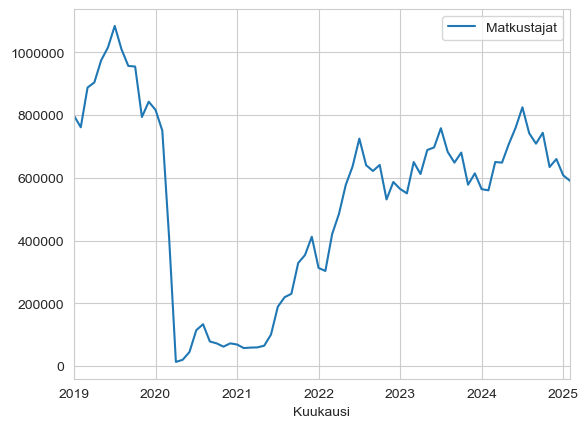

In [4]:
#Piirretään kaavio ja estetään ticklabel_format-funktiolla matkustajamäärien näyttäminen eksponettimuodossa. 
df.plot().ticklabel_format(style='plain', axis='y')

In [5]:
malli = ExponentialSmoothing(df['Matkustajat'],trend='add', seasonal = 'add', seasonal_periods = 12)
fit = malli.fit()
ennuste = fit.forecast()

#Tämä antaa varoistuksen, joka kertoo, että optimointi epäonnistui. Tämä johtuu datassa olevista isoista poikkeamista. Datassahan on mukana korona-aika, 
#jolloin matkustajamäärä oli todella alhainen. Tarkempaa virheilmoitusta voi tarkastella komennolla print(fit.mle_retvals)


C:\Users\Installer\miniconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [6]:
#Tarkastellaan dataa korona-ajan jälkeen ja katsotaan mitä tapahtuu. Tehdään alkuperäisestä dataframesta kopio, johon
#otetaan mukaan ainoastaan huhtikuu 2022 ja myöhemmät ajankohdat. 

df2 = df[df.index >='2022-4-1'].copy()

#Asetaan parametrit siten, että malli ja ennuste onnistuu paremmin. 

malli2 = ExponentialSmoothing(df2['Matkustajat'], trend = 'add', seasonal = 'mul', seasonal_periods = 12, use_boxcox = True)

#trend = 'add' --> Tasainen eli lineaarinen trendin nousu/lasku
#trend = 'mul' --> Suhteellinen eli prosentuaalinen trendin kasvu / lasku
#trend = 'none' --> Ei trendiä eli muutosta.

#seasonal = 'add' --> Kausivaihtelu on suurinpiirtein vakio koko ajan. Esim. helmikuussa on aina 50 000 enemmän/vähemmän kuin joulukuussa.
#seasonal = 'mul' --> Kausivaihtelu kasvaa/pienenee trendin mukana. Esim. helmikuussa on aina 2x enemmän/vähemmän kuin joulukuussa. 

#seasonal_periods --> Kausien määrä mallissa. Tässä data on kuukausittaista, eli kausia on 12. 

#use_box_cox = True. Matemaattinen korjaus, joka mahdollistaa optimoinnin. Kannattaa käyttää, kun käsiteltävät luvut ovat suuria. Teoria sivuutetaan 
#tällä opintojaksolla. 


#Opetetaan malli datalle ja laaditaan ennuste. 
fit2 = malli2.fit()
ennuste2 = fit2.forecast()

#Sijoitetaan ennuste dataframeen. 
df2['Ennuste'] = fit2.fittedvalues.round().astype(int)
df2


,Matkustajat,Ennuste
Kuukausi,,
2022-04-01,484832,484832
2022-05-01,577375,549301
2022-06-01,635909,612654
2022-07-01,724994,702000
2022-08-01,640280,648906
2022-09-01,621852,613954
2022-10-01,641118,648941
2022-11-01,531058,541362
2022-12-01,586679,567341


In [7]:
#Miten tiedetään, onko mallin antama ennuste hyvä? Kannattaa aluksi silmämääräisesti verrata mallin antamia lukuja toteutuneisiin. Mikäli
#ne ovat lähellä toisiaan, on ennuste todennäköisesti hyvä. Lisätään dataframeen sarake, joka näyttää eron toteutuneen ja ennustetun 
#matkustajamäärän välillä. Mikäli erot ovat suuria, kannattaa muuttaa edellisessä kohdassa parametrejä ja kokeilla uudelleen. 

df2['Erotus'] = df2['Matkustajat']-df2['Ennuste']

df2

,Matkustajat,Ennuste,Erotus
Kuukausi,,,
2022-04-01,484832,484832,0
2022-05-01,577375,549301,28074
2022-06-01,635909,612654,23255
2022-07-01,724994,702000,22994
2022-08-01,640280,648906,-8626
2022-09-01,621852,613954,7898
2022-10-01,641118,648941,-7823
2022-11-01,531058,541362,-10304
2022-12-01,586679,567341,19338


Text(0, 0.5, 'Toteutunut matkustajamäärä')

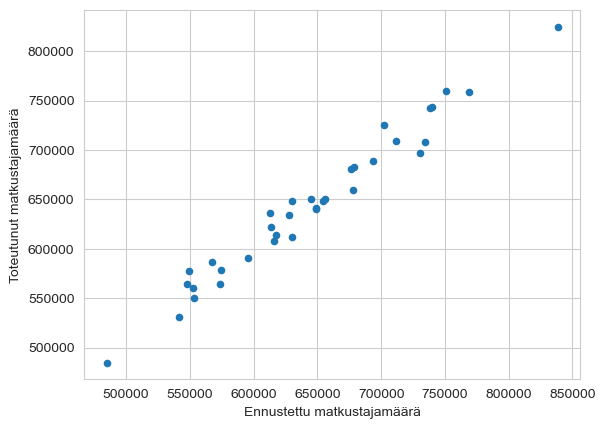

In [10]:
#Mallista kannattaa myös piirtää hajontakaavio toteutuneet arvot vs. ennustetut. 
#Mitä enemmän kuvio muistuttaa suoraa viivaa, sitä paremmin malli on osannut ennustaa. 

df2.plot(kind='scatter', x='Ennuste', y='Matkustajat')
plt.xlabel('Ennustettu matkustajamäärä')
plt.ylabel('Toteutunut matkustajamäärä')


In [9]:
#Ennustetaan seuraavaksi matkustajamäärät vuoden 2026 loppuun, eli 22 kuukautta eteenpäin.  

ennuste = fit2.forecast(22)
df_ennuste = pd.DataFrame({'Ennuste': ennuste}).round().astype(int)

df_ennuste

,Ennuste
2025-03-01,691815
2025-04-01,670509
2025-05-01,759219
2025-06-01,805117
2025-07-01,888379
2025-08-01,794621
2025-09-01,761484
2025-10-01,794287
2025-11-01,670178
2025-12-01,715612
